# POLI 179 Final Project
### By: Alyson Otañez 

### Setup

In [1]:
# Install and import packages
# ! pip install pandas
import pandas as pd

In [ ]:
# Load data 
chino = pd.read_csv('Data/chino_complete.csv')
fontana = pd.read_csv('Data/fontana_complete.csv')
marchjpa = pd.read_csv('Data/marchjpa_complete.csv')
ontario = pd.read_csv('Data/ontario_complete.csv')
rialto = pd.read_csv('Data/rialto_complete.csv')

### Data cleaning to combine datasets

In [ ]:
# Chino
chino = chino.drop(columns = ['industrial', 'recreation', 'housing', 'transportation', 'Unnamed: 0.1', 'Unnamed: 0'])
chino = chino.rename(columns = {'text': 'Text', 'date': 'Date', 'year': 'Year'})
chino['City'] = 'Chino'
chino

In [ ]:
# Fontana
fontana = fontana.drop(columns = 'PDF Link')
fontana['City'] = 'Fontana'
fontana

In [ ]:
# March JPA 
marchjpa = marchjpa.drop(columns = ['Unnamed: 0', 'PDF.Link'])
marchjpa['Year'] = marchjpa['Year'].fillna(0)
marchjpa['Year'] = marchjpa['Year'].astype(int)
marchjpa['City'] = 'March JPA'
marchjpa

In [ ]:
# Ontario
ontario = ontario.drop(columns = ['Unnamed: 0', 'PDF.Link'])
ontario['Year'] = ontario['Year'].fillna(0)
ontario['Year'] = ontario['Year'].astype(int)
ontario['City'] = 'Ontario'
ontario

In [ ]:
# Rialto 
rialto = rialto.drop(columns = 'PDF Link')
rialto['Year'] = rialto['Year'].fillna(0)
rialto['Year'] = rialto['Year'].astype(int)
rialto['City'] = 'Rialto'
rialto

### Combine data sets

In [ ]:
# Merge data sets
ie_cities = pd.concat([chino, fontana, marchjpa, ontario, rialto])

# Save as csv 
ie_cities.to_csv('ie_cities.csv', index = False)

## Exploratory 

####  Count of topics of interest over time

In [90]:
# Install packages if necessary 
# ! pip install pandas
# ! pip install re 
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install warnings 

In [84]:
# Import necessary packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [85]:
# Load data 
#ie_cities = pd.read_csv('../Data/ie_cities.csv')

In [86]:
# Keywords 
industrial = ['warehouse', 'logistics', 'distribution', 'industrial', 'warehousing']
recreation = ['recreation', 'park', 'green space', 'pool', 'outdoor']
transportation = ['transportation', 'bus', 'public transport', 'transit', 'train']

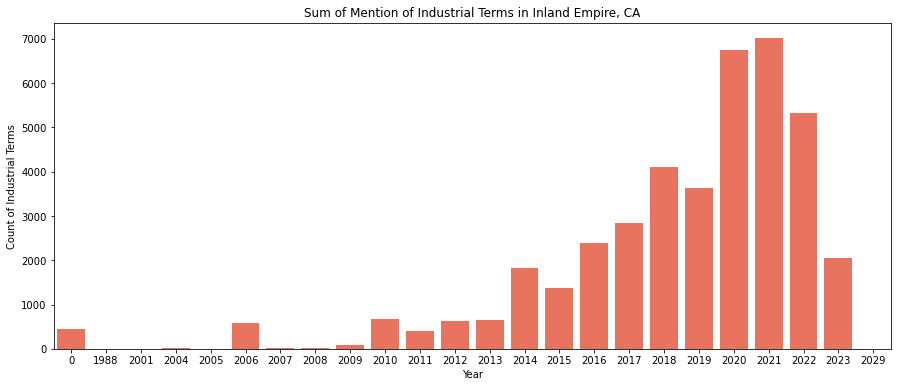

In [87]:
# Plot of industrial terms over time
def count_industrial(text):
    words = re.split(r'\s+', text.lower())  
    return sum(word in industrial for word in words)

# Apply the function to each text entry and create a new column for sums
ie_cities['sum_industrial'] = ie_cities['Text'].apply(count_industrial)

# Group by Year and sum the counts
yearly_counts_in = ie_cities.groupby('Year')['sum_industrial'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=yearly_counts_in, x='Year', y='sum_industrial', color='tomato')
plt.xlabel('Year')
plt.ylabel('Count of Industrial Terms')
plt.title('Sum of Mention of Industrial Terms in Inland Empire, CA')
plt.savefig('industrial_terms_plot.png')
plt.show()

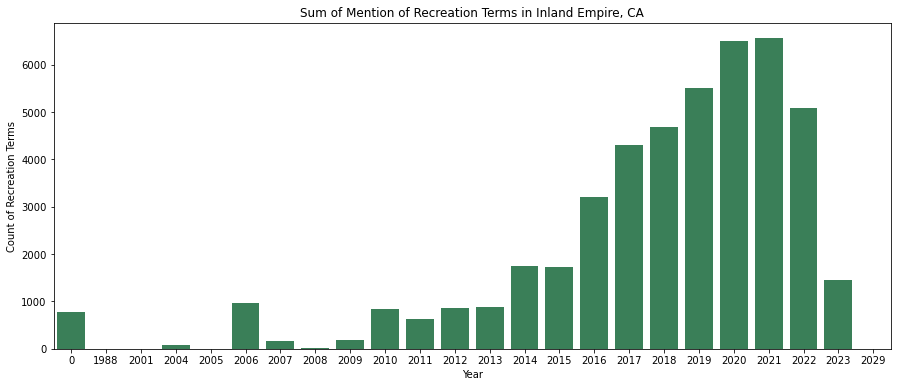

In [88]:
# Plot of recreation terms over time
def count_recreation(text):
    words = re.split(r'\s+', text.lower())  
    return sum(word in recreation for word in words)

# Apply the function to each text entry and create a new column for sums
ie_cities['sum_recreation'] = ie_cities['Text'].apply(count_recreation)

# Group by Year and sum the counts
yearly_counts_re = ie_cities.groupby('Year')['sum_recreation'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=yearly_counts_re, x='Year', y='sum_recreation', color='seagreen')
plt.xlabel('Year')
plt.ylabel('Count of Recreation Terms')
plt.title('Sum of Mention of Recreation Terms in Inland Empire, CA')
plt.savefig('recreation_terms_plot.png')
plt.show()

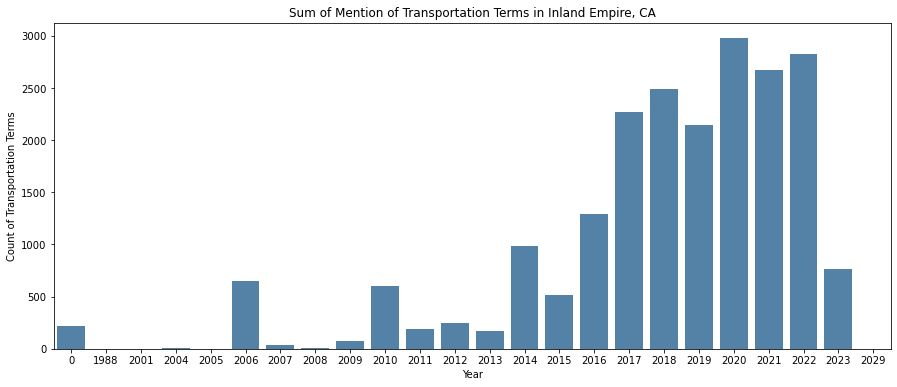

In [89]:
# Plot of transportation terms over time
def count_trans(text):
    words = re.split(r'\s+', text.lower())  
    return sum(word in transportation for word in words)

# Apply the function to each text entry and create a new column for sums
ie_cities['sum_transportation'] = ie_cities['Text'].apply(count_trans)

# Group by Year and sum the counts
yearly_counts_tr = ie_cities.groupby('Year')['sum_transportation'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=yearly_counts_tr, x='Year', y='sum_transportation', color='steelblue')
plt.xlabel('Year')
plt.ylabel('Count of Transportation Terms')
plt.title('Sum of Mention of Transportation Terms in Inland Empire, CA')
plt.savefig('trans_terms_plot.png')
plt.show()

## Linear Discriminant Analysis (LDA) 

### 1. Setup

In [91]:
# Install packages if necessary
# ! pip install nltk
# ! pip install spacy 
# ! pip install --user gensim
# ! pip install --user pyLDAvis
# ! pip install --user gutenbergpy

In [12]:
# Import necessary packages
import pandas as pd
import os
import nltk
import re
import string
import sys
sys.path.append('/home/aotanez/.local/lib/python3.9/site-packages')
import gensim
import numpy as np
from gutenbergpy import textget
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvisualize

### 2. Import data

In [27]:
# Load data 
ie_cities = pd.read_csv('../Data/ie_cities.csv')

# Drop NA values (only 1)
ie_cities = ie_cities[ie_cities['Text'].notna()]

ie_cities

,Text,Date,Year,City
0,«Back to Main Site\r\n Welc...,"December 20, 2005",2005,Chino
1,«Back to Main Site\r\n Welc...,"January 17, 2006",2006,Chino
2,«Back to Main Site\r\n Welc...,"March 9, 2006",2006,Chino
3,«Back to Main Site\r\n Welc...,"February 21, 2006",2006,Chino
4,«Back to Main Site\r\n Welc...,"March 7, 2006",2006,Chino
...,...,...,...,...
5521,"Tuesday, September 11, 2012\n5:00 PMCity of Ri...","Tuesday, September 11, 2012",2012,Rialto
5522,"Tuesday, August 28, 2012\n5:00 PMCity of Rialt...","Tuesday, August 28, 2012",2012,Rialto
5523,"Tuesday, August 14, 2012\n5:00 PMCity of Rialt...","Tuesday, August 14, 2012",2012,Rialto
5524,"Tuesday, July 24, 2012\n5:00 PMCity of Rialto\...","Tuesday, July 24, 2012",2012,Rialto


### 3. Preprocess data

In [36]:
# WordNet for lemmatization 
def wordnet_pos_tags(x):
    if x.startswith('J'):
        return wordnet.ADJ
    elif x.startswith('V'):
        return wordnet.VERB
    elif x.startswith('N'):
        return wordnet.NOUN
    elif x.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [40]:
# Function for preprocessing 
def txt_preprocess_pipeline(text):
    standard_txt = text.lower()
    clean_txt = re.sub(r'\n', ' ', standard_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = re.sub(r'http\S+|www\S+|https\S+', '', clean_txt, flags = re.MULTILINE)
    clean_txt = re.sub(r'\S+@\S+', '', clean_txt)
    clean_txt = re.sub(r'\\r\\n', ' ', clean_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = re.sub(r'<.*?>', '', clean_txt)
    clean_txt = re.sub(r'[^\w\s]', '', clean_txt)    
    clean_txt = re.sub(r'\b\w{1,2}\b', '', clean_txt)
    clean_txt = clean_txt.strip()
    tokens = word_tokenize(clean_txt)
    filtered_tokens_alpha = [word for word in tokens if word.isalpha() and not re.match(r'^[ivxlcdm]+$', word)]
    stop_words = stopwords.words('english')
    stop_words.extend(['chino', 'fontana', 'march', 'joint', 'powers', 'authority', 
                       'http', 'rialto', 'ontario', 'city', 'council', 'agenda',
                      'meeting', 'minutes'])
    filtered_tokens_final = [w for w in filtered_tokens_alpha if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(filtered_tokens_final)
    lemma_tokens = [lemmatizer.lemmatize(token, wordnet_pos_tags(pos_tag)) for token, pos_tag in pos_tags]
    return lemma_tokens

In [41]:
# File iteration function
def iterate_txt_files(txt_dir):
    texts = []
    for filename in os.listdir(txt_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(txt_dir, filename), 'r', encoding='utf-8') as file:
                txt_tokens = txt_preprocess_pipeline(file)
                texts.append(txt_tokens)
    return texts

In [42]:
# Apply functions to data
ie_cities['Processed_Text'] = ie_cities['Text'].apply(txt_preprocess_pipeline)
ie_cities

,Text,Date,Year,City,Processed_Text
0,«Back to Main Site\r\n Welc...,"December 20, 2005",2005,Chino,"[back, main, site, welcome, meeting, browse, v..."
1,«Back to Main Site\r\n Welc...,"January 17, 2006",2006,Chino,"[back, main, site, welcome, meeting, browse, v..."
2,«Back to Main Site\r\n Welc...,"March 9, 2006",2006,Chino,"[back, main, site, welcome, meeting, browse, v..."
3,«Back to Main Site\r\n Welc...,"February 21, 2006",2006,Chino,"[back, main, site, welcome, meeting, browse, v..."
4,«Back to Main Site\r\n Welc...,"March 7, 2006",2006,Chino,"[back, main, site, welcome, meeting, browse, v..."
...,...,...,...,...,...
5521,"Tuesday, September 11, 2012\n5:00 PMCity of Ri...","Tuesday, September 11, 2012",2012,Rialto,"[tuesday, september, pmcity, chamber, palm, av..."
5522,"Tuesday, August 28, 2012\n5:00 PMCity of Rialt...","Tuesday, August 28, 2012",2012,Rialto,"[tuesday, august, pmcity, chamber, palm, ave, ..."
5523,"Tuesday, August 14, 2012\n5:00 PMCity of Rialt...","Tuesday, August 14, 2012",2012,Rialto,"[tuesday, august, pmcity, palm, ave, chamber, ..."
5524,"Tuesday, July 24, 2012\n5:00 PMCity of Rialto\...","Tuesday, July 24, 2012",2012,Rialto,"[tuesday, july, pmcity, palm, ave, chamber, ma..."


### 4. LDA Topics

In [46]:
# Load dictionary
dictionary = corpora.Dictionary(ie_cities['Processed_Text'])
dictionary.filter_extremes(no_below = 2)

# Generate corpus as BoW
corpus = [dictionary.doc2bow(i) for i in  ie_cities['Processed_Text']]

In [47]:
# Train LDA model
lda_model = LdaModel(corpus = corpus, id2word = dictionary, random_state = 4583, 
                     chunksize = 20, num_topics = 15, passes = 200, iterations= 400)

# Print LDA topics
for idx, topic in lda_model.print_topics(num_topics = 15, num_words =10):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.000*"arequest" + 0.000*"tudents" + 0.000*"footstep" + 0.000*"feetjurupa" + 0.000*"elter" + 0.000*"bradbard" + 0.000*"behindthe" + 0.000*"behavio" + 0.000*"avepoplar" + 0.000*"icrochip"
Topic 2: 0.000*"arequest" + 0.000*"tudents" + 0.000*"footstep" + 0.000*"feetjurupa" + 0.000*"elter" + 0.000*"bradbard" + 0.000*"behindthe" + 0.000*"behavio" + 0.000*"avepoplar" + 0.000*"icrochip"
Topic 3: 0.000*"arequest" + 0.000*"tudents" + 0.000*"footstep" + 0.000*"feetjurupa" + 0.000*"elter" + 0.000*"bradbard" + 0.000*"behindthe" + 0.000*"behavio" + 0.000*"avepoplar" + 0.000*"icrochip"
Topic 4: 0.037*"level" + 0.034*"type" + 0.029*"owner" + 0.027*"structure" + 0.027*"cost" + 0.024*"rate" + 0.022*"fee" + 0.021*"potential" + 0.020*"authorize" + 0.018*"term"
Topic 5: 0.000*"arequest" + 0.000*"tudents" + 0.000*"footstep" + 0.000*"feetjurupa" + 0.000*"elter" + 0.000*"bradbard" + 0.000*"behindthe" + 0.000*"behavio" + 0.000*"avepoplar" + 0.000*"icrochip"
Topic 6: 0.000*"arequest" + 0.000*"tudents"

### 5. Evaluate Model

In [51]:
# Evaluate Model
coherence_model = CoherenceModel(model = lda_model, texts = ie_cities['Processed_Text'], 
                                 dictionary = dictionary, coherence = 'c_v')
coherence_score = coherence_model.get_coherence()
print(coherence_score)

### 6. Plot Topics

In [52]:
# Visualization
dickens_visual = gensimvisualize.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(dickens_visual)

# Download HTML version in GitHub to use interactive plot